# REU Poster Figures

In [389]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import argopy
import scipy.ndimage as filter
import cartopy.crs as ccrs
import cartopy
import xrft
import scipy
import matplotlib

In [390]:
font = {'family' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

## Useful Functions

In [391]:
def get_ds_interp(ds,depth_min,depth_max,sample_max):
    median_dp=ds.PRES.where(ds.PRES<depth_max).where(ds.PRES>depth_min).diff('N_LEVELS').median('N_LEVELS')
    ind_rate=median_dp.where(median_dp<sample_max,drop=True).N_PROF
    ds_sel=ds.sel(N_PROF=ind_rate)
    ds_interp=ds_sel.argo.interp_std_levels(np.arange(depth_min,depth_max,2)) #is this where we lose other variables?
    ds_interp=ds_interp.sortby(ds_interp.N_PROF)
    
    number=np.arange(0,len(ds_interp.N_PROF))
    ds_interp.coords['N_PROF_NEW']=xr.DataArray(number,dims=ds_interp.N_PROF.dims)
    return ds_interp

In [392]:
#question: the way we define sigma here doesn't involve dx and L_filt --> should it?

def get_ds_filt(ds_interp,first,last,num,variable='TEMP'):
    sigmas=np.logspace(first,last,num)
    temp=np.zeros((ds_interp.N_PROF.shape[0],ds_interp.PRES_INTERPOLATED.shape[0],num))

    for n in range(0,num):
        temp[:,:,n]=filter.gaussian_filter1d(ds_interp[variable],sigma=sigmas[n],mode='nearest')

    ds_filt=xr.DataArray(temp,dims=['N_PROF','PRES_INTERPOLATED','FILT_SCALE'],
             coords={'N_PROF':ds_interp.N_PROF,'PRES_INTERPOLATED':ds_interp.PRES_INTERPOLATED,'FILT_SCALE':sigmas})
    
    number=np.arange(0,len(ds_filt.N_PROF))
    ds_filt['N_PROF_NEW']=xr.DataArray(number,dims=ds_filt.N_PROF.dims)
    return ds_filt

In [393]:
def get_var(ds_interp,ds_filt,variable='TEMP'):
    var=np.zeros(len(ds_filt.FILT_SCALE))
    for n,sig in enumerate(so_filt.FILT_SCALE):
        prof=ds_filt.sel(FILT_SCALE=sig)
        var[n]=(prof-ds_interp[variable]).var()
    return var

In [394]:
def get_2_depths(ds,first,mid,last,sample_max,variable='TEMP'):
    interp_1=get_ds_interp(ds,first,mid,sample_max)
    interp_2=get_ds_interp(ds,mid,last,sample_max)
    
    filt_1=get_ds_filt(interp_1,0.5,2.5,50)
    filt_2=get_ds_filt(interp_2,0.5,2.5,50)
    
    var_1=get_var(interp_1,filt_1)
    var_2=get_var(interp_2,filt_2)
    
    return filt_1,var_1,filt_2,var_2

In [395]:
def get_3_depths(ds,first,mid1,mid2,last,sample_max,variable='TEMP'):
    interp_1=get_ds_interp(ds,first,mid1,sample_max)
    interp_2=get_ds_interp(ds,mid1,mid2,sample_max)
    interp_3=get_ds_interp(ds,mid2,last,sample_max)
    
    filt_1=get_ds_filt(interp_1,0.5,2.5,50)
    filt_2=get_ds_filt(interp_2,0.5,2.5,50)
    filt_3=get_ds_filt(interp_3,0.5,2.5,50)
    
    var_1=get_var(interp_1,filt_1)
    var_2=get_var(interp_2,filt_2)
    var_3=get_var(interp_3,filt_3)
    
    return filt_1,var_1,filt_2,var_2,filt_3,var_3

## Housekeeping

In [396]:
np_param=[-155,-145,30,35,0,2000]
np_ds=xr.open_dataset("202206_lon:(-155,-145)_lat:(30,35).nc")
na_param=[-55,-45,40,45,0,2000]
na_ds=xr.open_dataset("202206_lon:(-55,-45)_lat:(40,45).nc")
so_param=[30,40,-55,-50,0,2000]
so_ds=xr.open_dataset("202206_lon:(30,40)_lat:(-55,-50).nc")
io_param=[90,100,-15,-10,0,2000]
io_ds=xr.open_dataset("202206_lon:(90,100)_lat:(-15,-10).nc")

In [397]:
so_interp=get_ds_interp(so_ds,0,2000,3)
np_interp=get_ds_interp(np_ds,0,2000,3)
na_interp=get_ds_interp(na_ds,0,2000,3)
io_interp=get_ds_interp(io_ds,0,2000,3)

In [398]:
so_filt=get_ds_filt(so_interp,0.5,2.5,50)
np_filt=get_ds_filt(np_interp,0.5,2.5,50)
na_filt=get_ds_filt(na_interp,0.5,2.5,50)
io_filt=get_ds_filt(io_interp,0.5,2.5,50)

In [399]:
so_var=get_var(so_interp,so_filt)
np_var=get_var(np_interp,np_filt)
na_var=get_var(na_interp,na_filt)
io_var=get_var(io_interp,io_filt)

In [400]:
first,mid1,mid2,last,sample_max=0,200,1000,2000,3
so_filt_1,so_var_1,so_filt_2,so_var_2,so_filt_3,so_var_3=get_3_depths(so_ds,first,mid1,mid2,last,sample_max)
np_filt_1,np_var_1,np_filt_2,np_var_2,np_filt_3,np_var_3=get_3_depths(np_ds,first,mid1,mid2,last,sample_max)
na_filt_1,na_var_1,na_filt_2,na_var_2,na_filt_3,na_var_3=get_3_depths(na_ds,first,mid1,mid2,last,sample_max)
io_filt_1,io_var_1,io_filt_2,io_var_2,io_filt_3,io_var_3=get_3_depths(io_ds,first,mid1,mid2,last,sample_max)

## Data

#### Map of Boxes

In [401]:
np_lon,np_lat=np.average((np_param[0],np_param[1])),np.average((np_param[2],np_param[3]))
na_lon,na_lat=np.average((na_param[0],na_param[1])),np.average((na_param[2],na_param[3]))
so_lon,so_lat=np.average((so_param[0],so_param[1])),np.average((so_param[2],so_param[3]))
io_lon,io_lat=np.average((io_param[0],io_param[1])),np.average((io_param[2],io_param[3]))

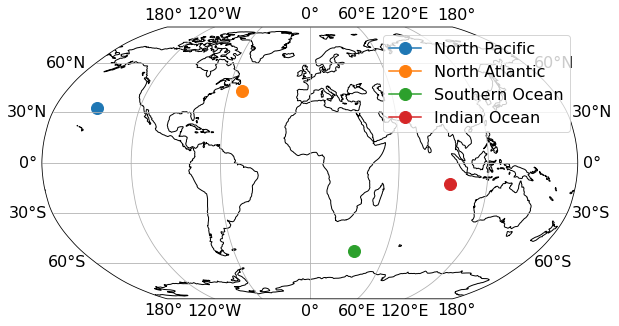

In [402]:
plt.figure(figsize=(10,5))
ax=plt.axes(projection=ccrs.Robinson())
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.plot(np_lon,np_lat,transform=ccrs.PlateCarree(),label='North Pacific',marker='o',markersize=12)
plt.plot(na_lon,na_lat,transform=ccrs.PlateCarree(),label='North Atlantic',marker='o',markersize=12)
plt.plot(so_lon,so_lat,transform=ccrs.PlateCarree(),label='Southern Ocean',marker='o',markersize=12)
plt.plot(io_lon,io_lat,transform=ccrs.PlateCarree(),label='Indian Ocean',marker='o',markersize=12)
plt.legend()

#### All Boxes Results

In [403]:
np_nmi=get_ds_interp(np_ds,300,2000,3)
na_nmi=get_ds_interp(na_ds,300,2000,3)
so_nmi=get_ds_interp(so_ds,300,2000,3)
io_nmi=get_ds_interp(io_ds,300,2000,3)

np_nmf=get_ds_filt(np_nmi,0.5,2.5,50)
na_nmf=get_ds_filt(na_nmi,0.5,2.5,50)
so_nmf=get_ds_filt(so_nmi,0.5,2.5,50)
io_nmf=get_ds_filt(io_nmi,0.5,2.5,50)

np_nmv=get_var(np_nmi,np_nmf)
na_nmv=get_var(na_nmi,na_nmf)
so_nmv=get_var(so_nmi,so_nmf)
io_nmv=get_var(io_nmi,io_nmf)

In [404]:
for interp in (np_interp,na_interp,so_interp,io_interp):
    interp.N_PROF_NEW.attrs.update({'long_name':'Relative Profile Number'})
    interp.TEMP.attrs.update({'long_name':'Temperature','units':'°C'})
    interp.PRES_INTERPOLATED.attrs.update({'long_name':'Interpolated Pressure','units':'db'})

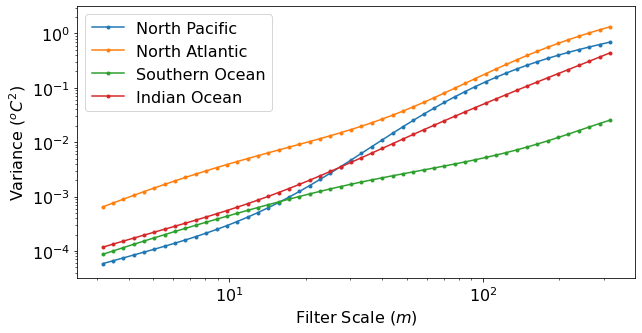

In [405]:
plt.figure(figsize=(10,5))
xs=[np_nmf.FILT_SCALE,na_nmf.FILT_SCALE,so_nmf.FILT_SCALE,io_nmf.FILT_SCALE]
ys=[np_nmv,na_nmv,so_nmv,io_nmv]
titles=['North Pacific','North Atlantic','Southern Ocean','Indian Ocean']

for n in range(0,4):
    plt.plot(xs[n],ys[n],'.-',label=titles[n])
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Filter Scale ($m$)")
    plt.ylabel("Variance ($^oC^2$)")
    plt.ylim(10**-4.5,10**0.5)
    #plt.xticks([0.02,0.01,0.1,0.2],labels=[50,100,10,5])
    
plt.subplots_adjust(hspace=0.4,wspace=0.4)
plt.legend()
#plt.title("Variance plot over (300m, 2000m) for four regions");

#### Methods Flowchart

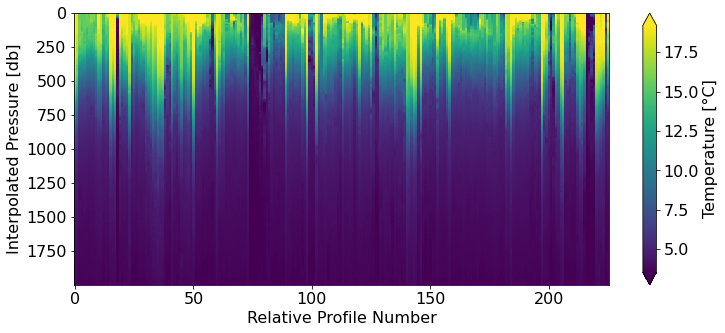

In [406]:
plt.figure(figsize=(12,5))
na_interp.TEMP.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',robust=True)
plt.gca().invert_yaxis()

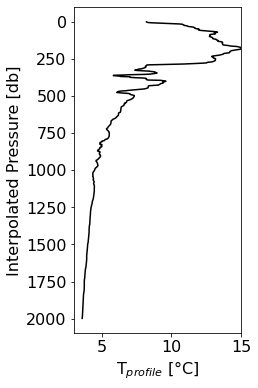

In [407]:
plt.figure(figsize=(3,6))
profile=na_interp.TEMP.isel(N_PROF=200)
profile.plot(y='PRES_INTERPOLATED',color='black')
plt.gca().invert_yaxis()
plt.xlabel('T$_{profile}$ [°C]')
plt.xlim(3,15)
plt.title('');

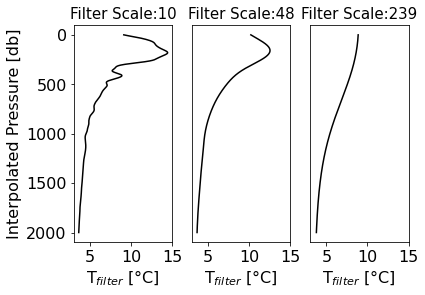

In [408]:
filt1,filt2,filt3=12,29,-4
filts=[na_filt.isel(N_PROF=200,FILT_SCALE=filt1),na_filt.isel(N_PROF=200,FILT_SCALE=filt2),na_filt.isel(N_PROF=200,FILT_SCALE=filt3)]
labels=[int(round(float(na_filt.FILT_SCALE[filt1]))),int(round(float(na_filt.FILT_SCALE[filt2]))),int(round(float(na_filt.FILT_SCALE[filt3])))]

plt.subplot(1,3,1)
filts[0].plot(y='PRES_INTERPOLATED',color='black')
plt.gca().invert_yaxis()
plt.xlabel('T$_{filter}$ [°C]')
plt.ylabel('Interpolated Pressure [db]')
plt.xlim(3,15)
plt.title('Filter Scale:{}'.format(labels[0]),fontsize=15)

plt.subplot(1,3,2)
filts[1].plot(y='PRES_INTERPOLATED',color='black')
plt.gca().invert_yaxis()
plt.yticks([])
plt.ylabel('')
plt.xlabel('T$_{filter}$ [°C]')
plt.xlim(3,15)
plt.title('Filter Scale:{}'.format(labels[1]),fontsize=15)

plt.subplot(1,3,3)
filts[2].plot(y='PRES_INTERPOLATED',color='black')
plt.gca().invert_yaxis()
plt.yticks([])
plt.ylabel('')
plt.xlabel('T$_{filter}$ [°C]')
plt.xlim(3,15)
plt.title('Filter Scale:{}'.format(labels[2]),fontsize=15);

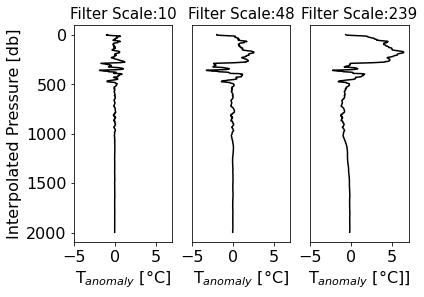

In [409]:
anoms=[profile-filts[0],profile-filts[1],profile-filts[2]]

plt.subplot(1,3,1)
anoms[0].plot(y='PRES_INTERPOLATED',color='black')
plt.gca().invert_yaxis()
plt.xlabel('T$_{anomaly}$ [°C]')
plt.xlim(-5,7)
plt.title('Filter Scale:{}'.format(labels[0]),fontsize=15)

plt.subplot(1,3,2)
anoms[1].plot(y='PRES_INTERPOLATED',color='black')
plt.gca().invert_yaxis()
plt.yticks([])
plt.ylabel('')
plt.xlabel('T$_{anomaly}$ [°C]')
plt.xlim(-5,7)
plt.title('Filter Scale:{}'.format(labels[1]),fontsize=15)

plt.subplot(1,3,3)
anoms[2].plot(y='PRES_INTERPOLATED',color='black')
plt.gca().invert_yaxis()
plt.yticks([])
plt.ylabel('')
plt.xlabel('T$_{anomaly}$ [°C]]')
plt.xlim(-5,7)
plt.title('Filter Scale:{}'.format(labels[2]),fontsize=15);

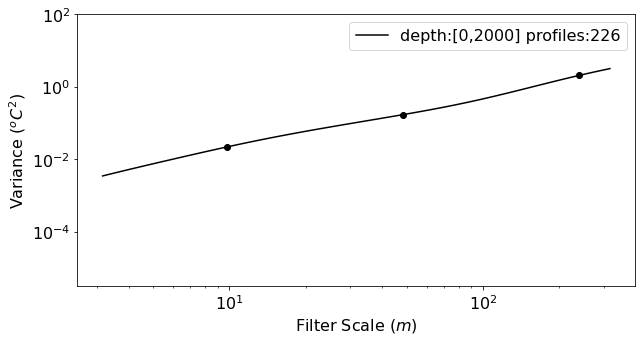

In [446]:
plt.figure(figsize=(10,5))

plt.plot(na_filt.FILT_SCALE[filt1],na_var[filt1],'o',color='black')
plt.plot(na_filt.FILT_SCALE[filt2],na_var[filt2],'o',color='black')
plt.plot(na_filt.FILT_SCALE[filt3],na_var[filt3],'o',color='black')
plt.plot(na_filt.FILT_SCALE,na_var,'-',color='black',label='depth:[0,2000] profiles:{}'.format(na_filt.N_PROF.shape[0]))

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Filter Scale ($m$)")
plt.ylabel("Variance ($^oC^2$)")
plt.ylim(10**-5.5,10**2);

#### Variance Plots

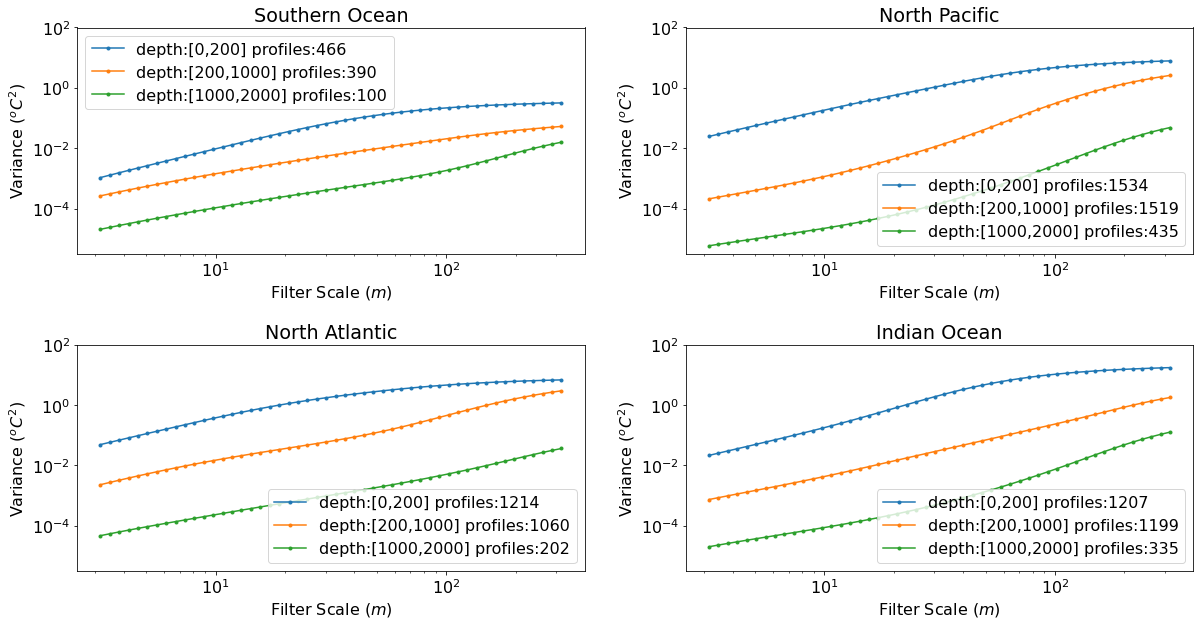

In [411]:
plt.figure(figsize=(20,10))
x1s=[so_filt_1.FILT_SCALE,np_filt_1.FILT_SCALE,na_filt_1.FILT_SCALE,io_filt_1.FILT_SCALE]
x2s=[so_filt_2.FILT_SCALE,np_filt_2.FILT_SCALE,na_filt_2.FILT_SCALE,io_filt_2.FILT_SCALE]
x3s=[so_filt_3.FILT_SCALE,np_filt_3.FILT_SCALE,na_filt_3.FILT_SCALE,io_filt_3.FILT_SCALE]
y1s=[so_var_1,np_var_1,na_var_1,io_var_1]
y2s=[so_var_2,np_var_2,na_var_2,io_var_2]
y3s=[so_var_3,np_var_3,na_var_3,io_var_3]
label1=[so_filt_1.N_PROF.shape[0],np_filt_1.N_PROF.shape[0],na_filt_1.N_PROF.shape[0],io_filt_1.N_PROF.shape[0]]
label2=[so_filt_2.N_PROF.shape[0],np_filt_2.N_PROF.shape[0],na_filt_2.N_PROF.shape[0],io_filt_2.N_PROF.shape[0]]
label3=[so_filt_3.N_PROF.shape[0],np_filt_3.N_PROF.shape[0],na_filt_3.N_PROF.shape[0],io_filt_3.N_PROF.shape[0]]
titles=['Southern Ocean','North Pacific','North Atlantic','Indian Ocean']

for n in range(0,4):
    plt.subplot(2,2,n+1)
    plt.plot(x1s[n],y1s[n],'.-',label='depth:[{},{}] profiles:{}'.format(first,mid1,label1[n]))
    plt.plot(x2s[n],y2s[n],'.-',label='depth:[{},{}] profiles:{}'.format(mid1,mid2,label2[n]))
    plt.plot(x3s[n],y3s[n],'.-',label='depth:[{},{}] profiles:{}'.format(mid2,last,label3[n]))
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Filter Scale ($m$)")
    plt.ylabel("Variance ($^oC^2$)")
    plt.ylim(10**-5.5,10**2)
    plt.title(titles[n])

plt.subplots_adjust(hspace=0.4,wspace=0.2)

#### Profile Plots

In [414]:
na_interp

<xarray.Dataset>
Dimensions:                (N_PROF: 226, PRES_INTERPOLATED: 1000)
Coordinates:
  * N_PROF                 (N_PROF) int64 89 90 91 92 93 ... 2974 2975 2978 2987
    TIME                   (N_PROF) datetime64[ns] 2022-03-10T00:01:45 ... 20...
    LATITUDE               (N_PROF) float64 40.02 40.76 41.2 ... 43.62 40.99
    LONGITUDE              (N_PROF) float64 -54.36 -52.24 ... -46.82 -47.51
  * PRES_INTERPOLATED      (PRES_INTERPOLATED) int64 0 2 4 6 ... 1994 1996 1998
    N_PROF_NEW             (N_PROF) int64 0 1 2 3 4 5 ... 221 222 223 224 225
Data variables:
    CONFIG_MISSION_NUMBER  (N_PROF) int32 4 4 4 4 4 4 4 ... 23 24 26 27 31 40
    CYCLE_NUMBER           (N_PROF) int32 12 14 15 16 17 18 ... 24 26 27 31 40
    DATA_MODE              (N_PROF) <U1 'R' 'R' 'R' 'R' 'R' ... 'D' 'D' 'A' 'A'
    DIRECTION              (N_PROF) <U1 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER        (N_PROF) int32 1902392 1902392 ... 5906438 5906438
    PRES                   (N_PROF, PRES_INTERPOLATED) float32 0.4 ... 1.998e+03
    PSAL                   (N_PROF, PRES_INTERPOLATED) float32 36.69 ... 34.95
    TEMP                   (N_PROF, PRES_INTERPOLATED) float32 20.2 ... 3.692
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         /swot/SUM05/dbalwada/202206-ArgoData
    Fetched_by:           amf2288
    Fetched_date:         2022/07/20
    Fetched_constraints:  [x=-55.00/-45.00; y=40.00/45.00; z=0.0/2000.0]
    Fetched_uri:          /swot/SUM05/dbalwada/202206-ArgoData/dac/meds/49006...
    history:              Variables filtered according to DATA_MODE; Variable...

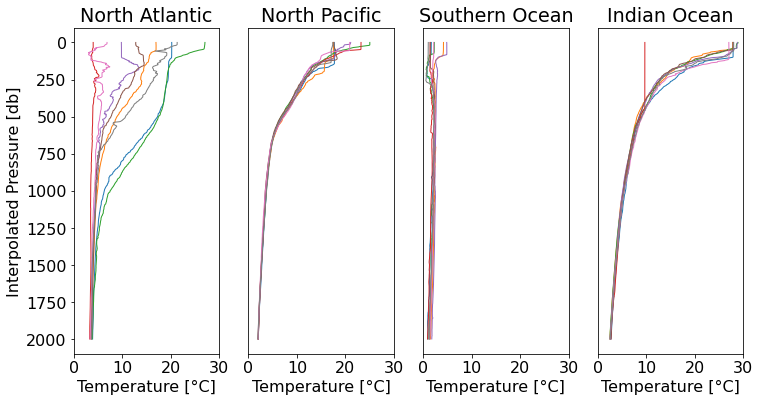

In [445]:
plt.figure(figsize=(12,6))

profiles=[0,25,50,75,-75,-50,-25,-1]

for n in range(0,len(profiles)):
    plt.subplot(1,4,1)
    prof=na_interp.isel(N_PROF=profiles[n])
    plt.plot(prof.TEMP,prof.PRES_INTERPOLATED,lw=1)
    plt.ylabel("Interpolated Pressure [db]")
    plt.xlabel('Temperature [°C]')
    plt.title("North Atlantic")
    plt.xlim(0,30)
    
    plt.subplot(1,4,2)
    prof=np_interp.isel(N_PROF=profiles[n])
    plt.plot(prof.TEMP,prof.PRES_INTERPOLATED,lw=1)
    plt.ylabel('')
    plt.yticks([])
    plt.xlim(0,30)
    plt.xlabel('Temperature [°C]')
    plt.title("North Pacific")
    
    plt.subplot(1,4,3)
    prof=so_interp.isel(N_PROF=profiles[n])
    plt.plot(prof.TEMP,prof.PRES_INTERPOLATED,lw=1)
    plt.ylabel('')
    plt.yticks([])
    plt.xlim(0,30)
    plt.xlabel('Temperature [°C]')
    plt.title('Southern Ocean')
    
    plt.subplot(1,4,4)
    prof=io_interp.isel(N_PROF=profiles[n])
    plt.plot(prof.TEMP,prof.PRES_INTERPOLATED,lw=1)
    plt.ylabel('')
    plt.yticks([])
    plt.xlim(0,30)
    plt.xlabel('Temperature [°C]')
    plt.title('Indian Ocean')

plt.subplot(1,4,1)
plt.gca().invert_yaxis()
plt.subplot(1,4,2)
plt.gca().invert_yaxis()
plt.subplot(1,4,3)
plt.gca().invert_yaxis()
plt.subplot(1,4,4)
plt.gca().invert_yaxis()